Can we predict what makes a student successful? (spoiler: it is not alcohol consumption)

![](29.06-portugal.jpg)

This dataset is  obtained in a survey of students math and portuguese language courses in secondary school. It contains social, gender and study information about students. It is recommended to  use it for some EDA or to predict students final grade.I used the publication by Paolo Cortez and Alice Silva to try out some regression and classification methods.

I will perform some basic EDA, prepare the data, perform some feature selection and try out some regression and classification methods. Finally I will reflect on the central question of this reseach: can we predict a student's final grade?  

I am beginning my data science journey. So there will be mistakes in this notebook. Constructive critisism and suggestions for improvement are very much welcome.



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

For this notebook I will only use the math dataset. Let start with getting some insights in the data.

In [2]:
data_full = pd.read_csv('student-mat.csv')

In [3]:
data_full.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [4]:
data_full.shape

(395, 33)

Let's see whether our data is categorical or numerical

In [5]:
data_full.dtypes

school        object
sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       int64
G1             int64
G2             int64
G3             int64
dtype: object

The heatmap below shows the correlation between the various features. The variables with the strongest correlation are G1 - first period grade and G2 - second period grade. To a lesser extent other features like 'failures' and the level of eduction of the student's mother contribute to the exam results. Alcohol consumption does not seem to influence much in this dataset.



<AxesSubplot:>

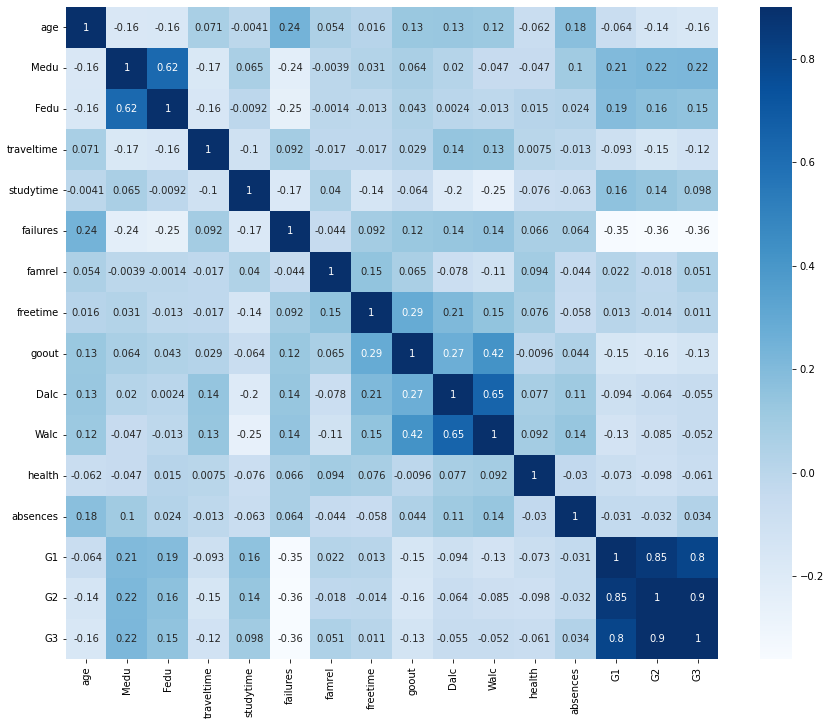

In [6]:
corr = data_full.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True, annot=True)



Let's check if there is any missing data.

In [7]:
data_full.isnull().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

Next we will analyse the distribution of the dependent variable, G3 - final grade. It seems like a almost normal distribution, apart from almost 40 students with 0 marks, which could be meaningful.

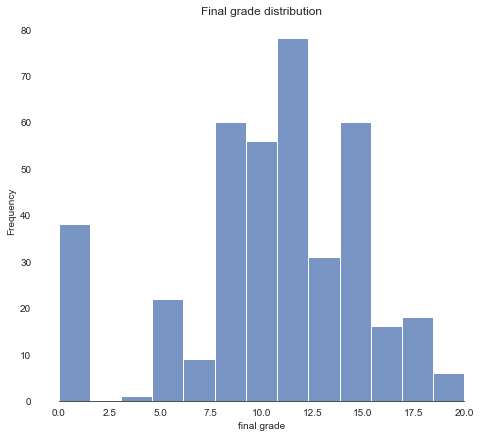

In [8]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.histplot(data_full['G3'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="final grade")
ax.set(title="Final grade distribution")
sns.despine(trim=True, left=True)
plt.show()

Now let's split the dataset in dependent (G3) and independent variables. I think we can use this dataset to test both regression and classification algorithms. I will use some methods to predict student's scores and also a few algorithms to predict whether a student will pass or fail the final exam. Therefore, I will prepare a binary version of the y-values for classification. 

In [9]:
y = data_full['G3']

data_full['G3'] = [1 if x >= 10 else 0 for x in data_full['G3']]

y_bool = data_full['G3']

data = data_full.drop(['G3'], axis=1)



In [10]:
# One-hot encode the data 
data = pd.get_dummies(data).reset_index(drop=True)


As we have seen in the heatmap, not all features seem to be relevant. We can use Lasso to select the most relevant variables. 

In [11]:
# Select features with lasso

feature_sel_model = SelectFromModel(Lasso(alpha=0.03, random_state=0)) 
feature_sel_model.fit(data, y)
feature_sel_model.get_support()

selected_feat = data.columns[(feature_sel_model.get_support())]

print('total features: {}'.format((data.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(feature_sel_model.estimator_.coef_ == 0)))
data = data[selected_feat]

total features: 58
selected features: 6
features with coefficients shrank to zero: 52


In [12]:
data.head()

,age,goout,Walc,absences,G1,G2
0,18,4,1,6,5,6
1,17,3,1,4,5,5
2,15,2,3,10,7,8
3,15,2,1,2,15,14
4,16,2,2,4,6,10


I will use the four regressions methods that are mentioned in the paper by Paulo Cortez and Alice Silva, which are Decision Trees, Random Forest, Neural Network and Linear Regresson, and I added XGBoost, as it was used in Kaggle's Intermediate Machine Learning course.

In [13]:
# Regression

X_train, X_valid, Y_train, Y_valid = train_test_split(data, y, test_size=0.2) 

DT_model = tree.DecisionTreeRegressor()
RF_model = RandomForestRegressor(n_estimators=500, random_state=0) # value of n_estimators based on Silva & Costa 
LinR_model = LinearRegression()
NN_model = MLPRegressor(random_state=0, hidden_layer_sizes=(393, 395, 395), max_iter=1500, early_stopping=True)
# Silva & Costa use, 1 layer, 100 epochs of the BFGS algorithm, but this does not perform well in my case
XGB_model = XGBRegressor(n_estimators=100, learning_rate=0.08)

DT_model.fit(X_train, Y_train)
RF_model.fit(X_train, Y_train)
LinR_model.fit(X_train, Y_train)
NN_model.fit(X_train, Y_train)
XGB_model.fit(X_train, Y_train)

DT_prediction = DT_model.predict(X_valid)
print("Decision Tree score: ", DT_model.score(X_train,Y_train))
mae_DT_prediction = mean_absolute_error(DT_prediction, Y_valid)
print("Mean Absolute Error: ", mae_DT_prediction)

RF_prediction = RF_model.predict(X_valid)
print("Random Forest score: ", RF_model.score(X_train,Y_train))
mae_RF_prediction = mean_absolute_error(RF_prediction, Y_valid)
print("Mean Absolute Error: ", mae_RF_prediction)

LinR_prediction = LinR_model.predict(X_valid)
print("Linear Regression score: ", LinR_model.score(X_train,Y_train))
mae_LinR_prediction = mean_absolute_error(LinR_prediction, Y_valid)
print("Mean Absolute Error: ", mae_LinR_prediction)

NN_prediction = NN_model.predict(X_valid)
print("Neural Network score: ", NN_model.score(X_train,Y_train))
mae_NN_prediction = mean_absolute_error(NN_prediction, Y_valid)
print("Mean Absolute Error: ", mae_NN_prediction)

XGB_prediction = XGB_model.predict(X_valid)
print("XGBoost score: ", XGB_model.score(X_train,Y_train))
mae_XGB_prediction = mean_absolute_error(XGB_prediction, Y_valid)
print("Mean Absolute Error: ", mae_XGB_prediction)


Decision Tree score:  1.0
Mean Absolute Error:  0.06329113924050633
Random Forest score:  0.9610073256367968
Mean Absolute Error:  0.11764556962025317
Linear Regression score:  0.5518097945142563
Mean Absolute Error:  0.267696083484194
Neural Network score:  0.750123699022327
Mean Absolute Error:  0.1714571106230215
XGBoost score:  0.993322449960204
Mean Absolute Error:  0.11979734628237312


Now let's see if we can use some classification algorithms to predict failure or success.

In [14]:
# Classification

X_train, X_valid, Y_train, Y_valid = train_test_split(data, y_bool, test_size=0.2) 

LR_model = LogisticRegression(max_iter=500)
SVC_model = SVC()
KNN_model = KNeighborsClassifier(n_neighbors=5)

LR_model.fit(X_train, Y_train)
SVC_model.fit(X_train, Y_train)
KNN_model.fit(X_train, Y_train)

LR_prediction = LR_model.predict(X_valid)
SVC_prediction = SVC_model.predict(X_valid)
KNN_prediction = KNN_model.predict(X_valid)

# print classification report
print('LR_prediction \n', classification_report(LR_prediction, Y_valid))
print('SVC_prediction \n',classification_report(SVC_prediction, Y_valid))
print('KNN_prediction \n',classification_report(KNN_prediction, Y_valid))

LR_prediction 
               precision    recall  f1-score   support

           0       0.92      0.85      0.88        26
           1       0.93      0.96      0.94        53

    accuracy                           0.92        79
   macro avg       0.92      0.90      0.91        79
weighted avg       0.92      0.92      0.92        79

SVC_prediction 
               precision    recall  f1-score   support

           0       0.83      0.87      0.85        23
           1       0.95      0.93      0.94        56

    accuracy                           0.91        79
   macro avg       0.89      0.90      0.89        79
weighted avg       0.91      0.91      0.91        79

KNN_prediction 
               precision    recall  f1-score   support

           0       0.83      0.80      0.82        25
           1       0.91      0.93      0.92        54

    accuracy                           0.89        79
   macro avg       0.87      0.86      0.87        79
weighted avg       0.89 

The algorithms seem to work well. The neural network is outperformed by others. Cortez & Silva explain that this is due to the presenc of irrelevant data. In my case it could also be a lack of understanding how to tweak MLPRegressor correctly. As pointed out by Cortez & Silva, student achievement is highly influenced by previous performances, in particular by the variables G2 and G1. However, I would argue that this does not explain well what makes a student successful or not. Passing the G1 and G2 exams certainly depend on other factors. A successful student will pass all the exams, but what makes the difference? Does this dataset provide some insight in other variables that could predict a student's final mark? Therefore, let's drop the exam results and focus on the other features, perform the same pipeline and see whether the remaining data can predict the final exam outcomes.


In [15]:
data_clean = data_full.drop(['G3', 'G2', 'G1'], axis=1)

In [16]:
# One-hot encode the data 
data_clean = pd.get_dummies(data_clean).reset_index(drop=True)

In [17]:
# Select features with lasso

feature_sel_model = SelectFromModel(Lasso(alpha=0.01, random_state=0)) 
feature_sel_model.fit(data_clean, y)
feature_sel_model.get_support()

selected_feat = data_clean.columns[(feature_sel_model.get_support())]

print('total features: {}'.format((data_clean.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(feature_sel_model.estimator_.coef_ == 0)))
data = data_clean[selected_feat]

total features: 56
selected features: 17
features with coefficients shrank to zero: 37


In [18]:
data.head()

,age,Medu,Fedu,studytime,failures,famrel,freetime,goout,Walc,health,absences,sex_F,Mjob_services,reason_course,schoolsup_no,famsup_no,romantic_no
0,18,4,4,2,0,4,3,4,1,3,6,1,0,1,0,1,1
1,17,1,1,2,0,5,3,3,1,3,4,1,0,1,1,0,1
2,15,1,1,2,3,4,3,2,3,3,10,1,0,0,0,1,1
3,15,4,2,3,0,3,2,2,1,5,2,1,0,0,1,0,0
4,16,3,3,2,0,4,3,2,2,5,4,1,0,0,1,0,1


In [19]:
# Regression

X_train, X_valid, Y_train, Y_valid = train_test_split(data_clean, y, test_size=0.2) 

DT_model = tree.DecisionTreeRegressor()
RF_model = RandomForestRegressor(n_estimators=500, random_state=0) 
LinR_model = LinearRegression()
NN_model = MLPRegressor(random_state=0, hidden_layer_sizes=(395, 395, 395), max_iter=1500, early_stopping=True)
XGB_model = XGBRegressor(n_estimators=100, learning_rate=0.05)

DT_model.fit(X_train, Y_train)
RF_model.fit(X_train, Y_train)
LinR_model.fit(X_train, Y_train)
NN_model.fit(X_train, Y_train)
XGB_model.fit(X_train, Y_train)

DT_prediction = DT_model.predict(X_valid)
print("Decision Tree score: ", DT_model.score(X_train,Y_train))
mae_DT_prediction = mean_absolute_error(DT_prediction, Y_valid)
print("Mean Absolute Error: ", mae_DT_prediction)

RF_prediction = RF_model.predict(X_valid)
print("Random Forest score: ", RF_model.score(X_train,Y_train))
mae_RF_prediction = mean_absolute_error(RF_prediction, Y_valid)
print("Mean Absolute Error: ", mae_RF_prediction)

LinR_prediction = LinR_model.predict(X_valid)
print("Linear Regression score: ", LinR_model.score(X_train,Y_train))
mae_LinR_prediction = mean_absolute_error(LinR_prediction, Y_valid)
print("Mean Absolute Error: ", mae_LinR_prediction)

NN_prediction = NN_model.predict(X_valid)
print("Neural Network score: ", NN_model.score(X_train,Y_train))
mae_NN_prediction = mean_absolute_error(NN_prediction, Y_valid)
print("Mean Absolute Error: ", mae_NN_prediction)

XGB_prediction = XGB_model.predict(X_valid)
print("XGBoost score: ", XGB_model.score(X_train,Y_train))
mae_XGB_prediction = mean_absolute_error(XGB_prediction, Y_valid)
print("Mean Absolute Error: ", mae_XGB_prediction)


Decision Tree score:  1.0
Mean Absolute Error:  0.35443037974683544
Random Forest score:  0.874946109796999
Mean Absolute Error:  0.35645569620253165
Linear Regression score:  0.2218398210262278
Mean Absolute Error:  0.31969910633714893
Neural Network score:  0.4596263684349212
Mean Absolute Error:  0.3932687576780837
XGBoost score:  0.9262563098912507
Mean Absolute Error:  0.3528130169297698


In [20]:
# Classification

X_train, X_valid, Y_train, Y_valid = train_test_split(data_clean, y_bool, test_size=0.2) 

LR_model = LogisticRegression(max_iter=500)
SVC_model = SVC()
KNN_model = KNeighborsClassifier(n_neighbors=5)

LR_model.fit(X_train, Y_train)
SVC_model.fit(X_train, Y_train)
KNN_model.fit(X_train, Y_train)

LR_prediction = LR_model.predict(X_valid)
SVC_prediction = SVC_model.predict(X_valid)
KNN_prediction = KNN_model.predict(X_valid)

# print classification report
print('LR_prediction \n', classification_report(LR_prediction, Y_valid))
print('SVC_prediction \n',classification_report(SVC_prediction, Y_valid))
print('KNN_prediction \n',classification_report(KNN_prediction, Y_valid))


LR_prediction 
               precision    recall  f1-score   support

           0       0.50      0.50      0.50        20
           1       0.83      0.83      0.83        59

    accuracy                           0.75        79
   macro avg       0.67      0.67      0.67        79
weighted avg       0.75      0.75      0.75        79

SVC_prediction 
               precision    recall  f1-score   support

           0       0.05      0.50      0.09         2
           1       0.98      0.75      0.85        77

    accuracy                           0.75        79
   macro avg       0.52      0.63      0.47        79
weighted avg       0.96      0.75      0.83        79

KNN_prediction 
               precision    recall  f1-score   support

           0       0.30      0.40      0.34        15
           1       0.85      0.78      0.81        64

    accuracy                           0.71        79
   macro avg       0.57      0.59      0.58        79
weighted avg       0.74 

Without considering the previous exam results, the algorithms struggle to predict well. In the case of classification, the models present strong class imbalances, as they prodominantly predict that students will pass the exam (especially in the case of SVM). Same for situation for the regression algorithms. For the regression algorithms, the MAE is much worse, making this dataset less useable for predictions. 
It seems to me that the dataset does not perform very well to explain and predict what makes a student successful or not. To predict student performance better, probably other variables might be considered, like the quality of the school, the teachers and learning materials used, motivation of the student, their IQ, the composition of the class and socio-economical factors.



Sources:
USING DATA MINING TO PREDICT SECONDARY SCHOOL STUDENT PERFORMANCE, Paulo Cortez and Alice Silva
http://www3.dsi.uminho.pt/pcortez/student.pdf
Lasso: https://github.com/krishnaik06/Advanced-House-Price-Prediction-
Kaggle Dataset: https://www.kaggle.com/uciml/student-alcohol-consumption
kaggle Intermediate Machine Learing Course: https://www.kaggle.com/learn/intermediate-machine-learning
Classification; https://stackabuse.com/overview-of-classification-methods-in-python-with-scikit-learn/
Image: https://odinland.vn/a-comprehensive-guide-about-the-education-system-in-portugal/?lang=en
https://www.youtube.com/watch?v=1JXrxCJoHuw&list=PLZoTAELRMXVMcRQwR5_J8k9S7cffVFq_U&index=6